In [1]:
%matplotlib inline
import seaborn as sns

import matplotlib as mpl
import matplotlib.pylab as plt

In [2]:
sns.set_palette('viridis')
sns.set_style('whitegrid', {'axes.grid' : False})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves

In [3]:
import biom
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict

In [4]:
import skbio
from skbio import TreeNode
from skbio.diversity import beta_diversity
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa


In [5]:
sns.__version__

'0.9.0'

# Parameters

In [6]:
save_files = True
debug = True

In [7]:
taxonomy_ranks = ('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species')
phylo_beta_types = 'weighted_unifrac unweighted_unifrac'.split()
simple_beta_types = 'jaccard braycurtis'.split()

In [8]:
# parameters
biom_file = 'final_otus.biom'
sample_metadata_file = 'sample_metadata.tsv'
otu_taxonomy_file = 'final_otus.qiime_format.taxonomy'
rooted_tree_file = 'final_otus.rooted.tree'
metadata_plot_categories = ('treatment',)

exclude_samples_by_metadata = {
    'DNA_source': ('terminal_ileum',),
}

min_sample_size = 1000
normalize_samples_to = 10000

# Parse Inputs

In [9]:
biom_table = biom.load_table(biom_file)
count_df = biom_table.to_dataframe()
if debug:
    display(count_df.info())

<class 'pandas.core.sparse.frame.SparseDataFrame'>
Index: 571 entries, Zotu1 to Zotu99
Columns: 153 entries, 3_21_10B to 7_13_ti_8R
dtypes: Sparse[float64, nan](153)
memory usage: 688.2+ KB


None

In [10]:
sample_md = pd.read_csv(sample_metadata_file, sep='\t', index_col=0)
sample_md.reset_index(inplace=True)
sample_md['index'] = sample_md['index'].str.replace('-','_')
sample_md = sample_md.set_index('index')
if debug:
    display(sample_md.head())

,DNA_source,cage,days_in,diet,food_condition,mouse,treatment
index,,,,,,,
3_21_10B,stool,10,0.0,NC,fed,10B,AZ51
3_21_10L,stool,10,0.0,NC,fed,10L,AZ51
3_21_10N,stool,10,0.0,NC,fed,10N,AZ51
3_21_10R,stool,10,0.0,NC,fed,10R,AZ51
3_21_14L,stool,14,0.0,NC,fed,14L,AZ52


In [11]:
set(sample_md.days_in)

{0.0, 13.0, 14.0, 70.0, 72.0, 112.0, 114.0}

In [12]:
# separate out into pre-treatment and post-treatment (segregate by days_in)
sample_md['week'] = sample_md.apply(lambda x: round(x.days_in / 7), axis=1)
sample_md['treatment_week'] = sample_md.apply(lambda x: '{}_{:02d}'.format(x.treatment, x.week), axis=1)
if debug:
    display(set(sample_md.treatment_week))

{'AZ51_00',
 'AZ51_02',
 'AZ51_10',
 'AZ51_16',
 'AZ52_00',
 'AZ52_02',
 'AZ52_10',
 'AZ52_16',
 'Vehicle_00',
 'Vehicle_02',
 'Vehicle_10',
 'Vehicle_16'}

In [13]:
tax = {}
with open(otu_taxonomy_file) as tax_file:
    next(tax_file)  # drop header row
    for otu, tax_path, _ in (l.rstrip().split('\t') for l in tax_file):
        tax[otu] = dict(zip(taxonomy_ranks, tax_path.split(';')))
tax_df = pd.DataFrame.from_dict(tax, orient='index')
if debug:
    display(tax_df.head())

,Kingdom,Phylum,Class,Order,Family,Genus
Zotu1,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Zotu10,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Zotu100,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_unclassified
Zotu101,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Clostridiaceae_1_unclassified
Zotu1012,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae_UCG-010


In [14]:
tree = None
with open(rooted_tree_file) as fh:
   tree = TreeNode.read(fh)

# Colors

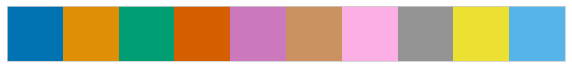

In [15]:
pal = sns.color_palette('colorblind')
sns.palplot(pal)

In [16]:
# per-sample_week colors
sampling_weeks = sorted(set(sample_md.week))
treatments = sorted(set(sample_md.treatment))
treatment_week_pal = {}
for n, treatment in enumerate(treatments):
    treatment_week_pal[treatment] = pal[n]
    col_pal = sns.light_palette(pal[n], len(sampling_weeks))
    for m, week in enumerate(sampling_weeks):
        treat_week = '{}_{:02d}'.format(treatment, week)
        treatment_week_pal[treat_week] = col_pal[m]
if debug:
    display(treatment_week_pal)
        
        

{'AZ51': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 'AZ51_00': array([0.90055866, 0.96424581, 0.99944134, 1.        ]),
 'AZ51_02': array([0.60167963, 0.79315734, 0.89897397, 1.        ]),
 'AZ51_10': array([0.3028006 , 0.62206886, 0.79850659, 1.        ]),
 'AZ51_16': array([0.00392157, 0.45098039, 0.69803922, 1.        ]),
 'AZ52': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'AZ52_00': array([0.99779736, 0.96299559, 0.90220264, 1.        ]),
 'AZ52_02': array([0.95539432, 0.82892517, 0.60800438, 1.        ]),
 'AZ52_10': array([0.91299128, 0.69485474, 0.31380611, 1.        ]),
 'AZ52_16': array([0.87058824, 0.56078431, 0.01960784, 1.        ]),
 'Vehicle': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'Vehicle_00': array([0.90125 , 0.99875 , 0.971875, 1.      ]),
 'Vehicle_02': array([0.60344771, 0.87236928, 0.79824346, 1.        ]),
 'Vehicle_10': array([0.30564542, 0.74598856, 0.62461193, 1.        ]),
 'Vehicle_16': array

# Filter out unwanted/too-small samples

In [17]:
md_columns = sample_md.columns
count_df_t_md = count_df.T.join(sample_md, how='left')
assert(not count_df_t_md.T.isna().any().any()) # no nulls on join

good_samples = set(md_columns)
new_df = count_df_t_md
if exclude_samples_by_metadata:
    for (md_col, md_vals) in exclude_samples_by_metadata.items():
        bad_samples = new_df[md_col].isin(md_vals)
        new_df = count_df_t_md[~bad_samples]

        
count_df = new_df.drop(md_columns, axis='columns').T
count_df = count_df.T[count_df.sum() >= min_sample_size].T
if debug:
    display(count_df.info())
    

<class 'pandas.core.frame.DataFrame'>
Index: 571 entries, Zotu1 to Zotu99
Columns: 121 entries, 3_21_10B to 7_11_8R
dtypes: float64(121)
memory usage: 564.2+ KB


None

# Normalize Table

In [18]:
norm_df = count_df
if normalize_samples_to:
    norm_df = count_df * normalize_samples_to / count_df.sum()
if debug:
    display(norm_df.head())

,3_21_10B,3_21_10L,3_21_10N,3_21_10R,3_21_14L,3_21_14N,3_21_14R,3_21_15B,3_21_15L,3_21_15R,...,7_11_3B,7_11_3L,7_11_3N,7_11_3R,7_11_4B,7_11_4N,7_11_8B,7_11_8L,7_11_8N,7_11_8R
Zotu1,2.293683,5.335325,7.556131,2.301761,1821.162864,1616.727616,1107.544141,2260.458289,1903.331513,1165.459370,...,3045.765632,1161.687609,2778.961790,2249.920230,1071.520255,1125.186701,1404.661306,2653.816337,2383.100609,1366.671942
Zotu10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.617360,198.157058,332.371070,59.528079,...,526.095256,230.090705,646.217080,0.398851,434.871900,834.762405,301.758212,797.096342,264.590047,656.749486
Zotu100,76.609019,20.807768,43.717617,7.480723,8.109728,0.000000,19.755525,37.511213,1.170321,27.253819,...,16.760557,126.903553,34.251789,0.000000,17.456487,19.361620,3.271092,2.819085,0.000000,0.949517
Zotu101,0.917473,2.134130,0.000000,1.150880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.398851,0.000000,0.000000,0.000000,1.057157,0.716076,0.000000
Zotu1012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
beta_div = {}
matrix = norm_df.T.to_numpy()
sample_ids = tuple(norm_df.columns)
obs_ids = tuple(norm_df.index)
for metric in phylo_beta_types:
    beta_div[metric] = beta_diversity(metric, matrix, sample_ids, otu_ids=obs_ids, tree=tree)
for metric in simple_beta_types:
    beta_div[metric] = beta_diversity(metric, matrix, sample_ids)
    

/opt/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [20]:
# Pairwise Permanovas
samples_by_md = {}
for week in set(sample_md.week):
    samples_by_md[week] = set(sample_md[sample_md.week == week].index)
for treatment in set(sample_md.treatment):
    samples_by_md[treatment] = set(sample_md[sample_md.treatment == treatment].index)
pairwise_unifrac = defaultdict(lambda: defaultdict(dict))
pairwise_permanova = defaultdict(lambda: defaultdict(dict))
pairwise_permanova_for_df = [] 
for metric, dist_matrix in beta_div.items():
    for treat1, treat2 in combinations(sorted(set(sample_md.treatment)),2):
        treat_pair = frozenset((treat1, treat2))
        treat_a, treat_b = tuple(treat_pair)
        treat_samples = (samples_by_md[treat1] | samples_by_md[treat2]) & set(dist_matrix.ids)
        pairwise_unifrac[metric][treat_pair] = dist_matrix.filter(treat_samples)
        pairwise_permanova[metric][treat_pair] = permanova(pairwise_unifrac[metric][treat_pair], sample_md, 'treatment')
        for week in set(sample_md.week):
            week_samples = treat_samples & samples_by_md[week]
            pairwise_unifrac[metric][week][treat_pair] = dist_matrix.filter(week_samples)
            perma = permanova(pairwise_unifrac[metric][treat_pair], sample_md, 'treatment')
            pairwise_permanova[metric][week][treat_pair] = perma
            pairwise_permanova_for_df.append({
                'metric': metric,
                'week': week,
                'treatment_a': treat_a,
                'treatment_b': treat_b,
                'p_value': perma['p-value'],
                'pseudo_F': perma['test statistic']
            })
pairwise_permanova_df = pd.DataFrame(
    pairwise_permanova_for_df, 
    columns=['metric', 'week', 'treatment_a', 'treatment_b', 'p_value', 'pseudo_F']
).sort_values(by=['metric', 'week', 'treatment_a', 'treatment_b'])
if debug:
    display(pairwise_permanova_df)

,metric,week,treatment_a,treatment_b,p_value,pseudo_F
36,braycurtis,0,AZ51,AZ52,0.034,2.120351
40,braycurtis,0,Vehicle,AZ51,0.001,4.262559
44,braycurtis,0,Vehicle,AZ52,0.123,1.490785
38,braycurtis,2,AZ51,AZ52,0.024,2.120351
42,braycurtis,2,Vehicle,AZ51,0.001,4.262559
46,braycurtis,2,Vehicle,AZ52,0.123,1.490785
39,braycurtis,10,AZ51,AZ52,0.034,2.120351
43,braycurtis,10,Vehicle,AZ51,0.001,4.262559
47,braycurtis,10,Vehicle,AZ52,0.116,1.490785
37,braycurtis,16,AZ51,AZ52,0.031,2.120351


In [21]:
# Weekwise Permanovas
weekwise_unifrac = defaultdict(dict)
weekwise_permanova = defaultdict(dict)
weekwise_permanova_for_df = [] 
for metric, dist_matrix in beta_div.items():
    for week in set(sample_md.week):
        week_samples = samples_by_md[week] & set(dist_matrix.ids)
        weekwise_unifrac[metric][week] = dist_matrix.filter(week_samples)
        perma = permanova(weekwise_unifrac[metric][week], sample_md.T[week_samples].T, 'treatment')
        weekwise_permanova[metric][week] = perma
        weekwise_permanova_for_df.append({
            'metric': metric,
            'week': week,
            'p_value': perma['p-value'],
            'pseudo_F': perma['test statistic']
        })
weekwise_permanova_df = pd.DataFrame(
    weekwise_permanova_for_df, 
    columns=['metric', 'week', 'p_value', 'pseudo_F']
).sort_values(by=['metric', 'week'])
if debug:
    display(weekwise_permanova_df)

,metric,week,p_value,pseudo_F
12,braycurtis,0,0.086,1.805583
14,braycurtis,2,0.001,2.478532
15,braycurtis,10,0.009,2.045524
13,braycurtis,16,0.216,1.190350
8,jaccard,0,0.133,1.332408
10,jaccard,2,0.001,2.034225
11,jaccard,10,0.001,1.916702
9,jaccard,16,0.001,2.364900
4,unweighted_unifrac,0,0.070,1.777075
6,unweighted_unifrac,2,0.001,2.294118


In [22]:
pcoa_2d = {}
for metric, distance in beta_div.items():
    pcoa_2d[metric] = pcoa(distance, number_of_dimensions=2)

/opt/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.07659200659021907 and the largest is 3.190474198456075.
  RuntimeWarning
/opt/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more deta

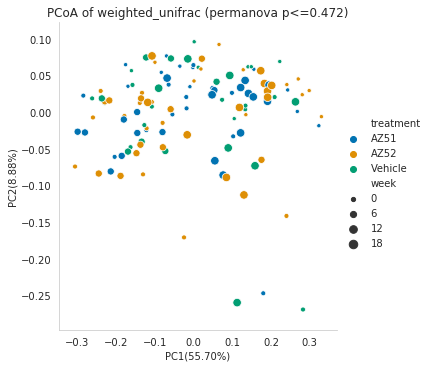

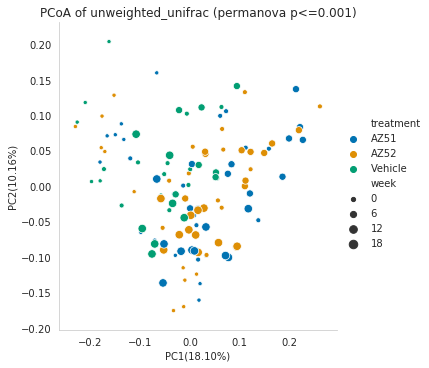

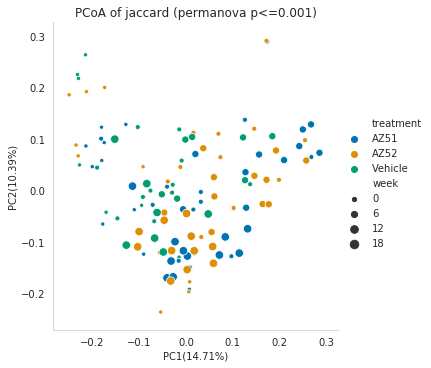

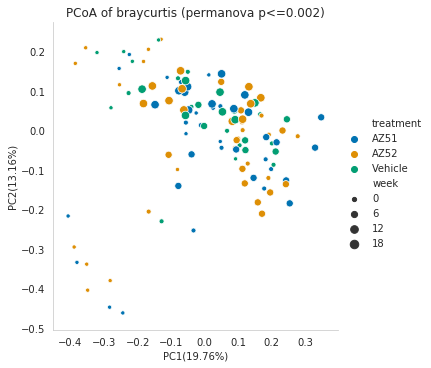

In [23]:
# combined
for metric, ordination in pcoa_2d.items():
    ordin_md = ordination.samples.join(sample_md, how='left')
    for cat in metadata_plot_categories:
        factors_in_cat = len(set(ordin_md[cat]))
        perm = permanova(beta_div[metric], sample_md, column=cat)
        p = sns.relplot(data=ordin_md, x='PC1', y='PC2', hue=cat, palette=pal[:factors_in_cat], size='week', marker='o')
        p.set_axis_labels(f'PC1({ordination.proportion_explained.PC1:.2%})', 
                          f'PC2({ordination.proportion_explained.PC2:.2%})')
        plt.title(f'PCoA of {metric} (permanova p<={perm["p-value"]:0.3f})')
        plt.plot()
        if save_files:
            plt.savefig(f'pcoa_{metric}_{cat}.svg')

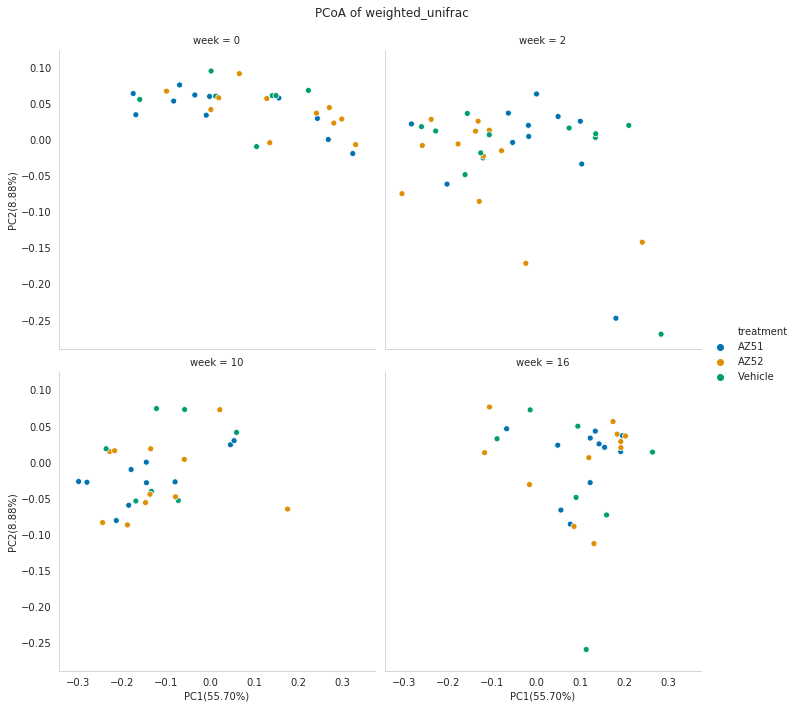

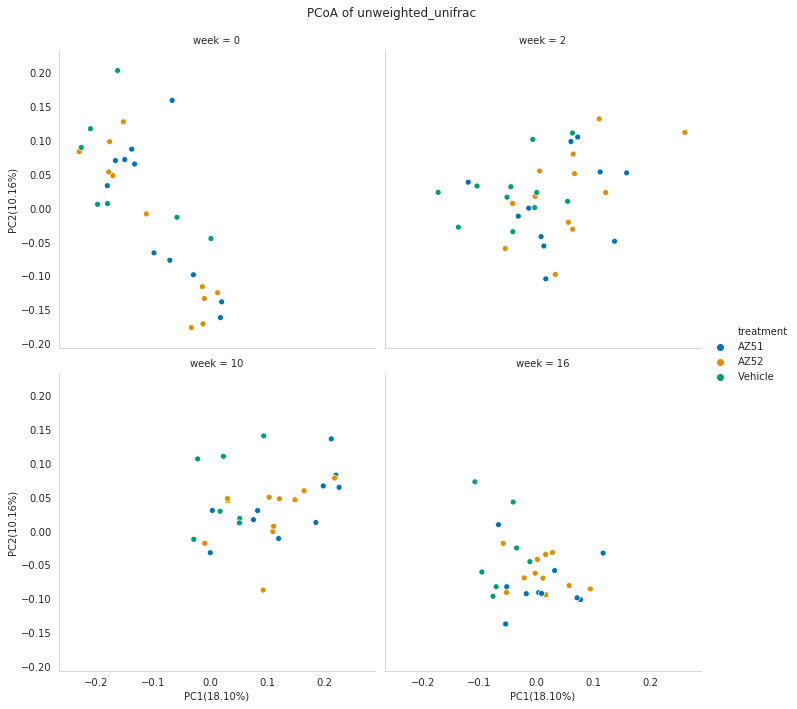

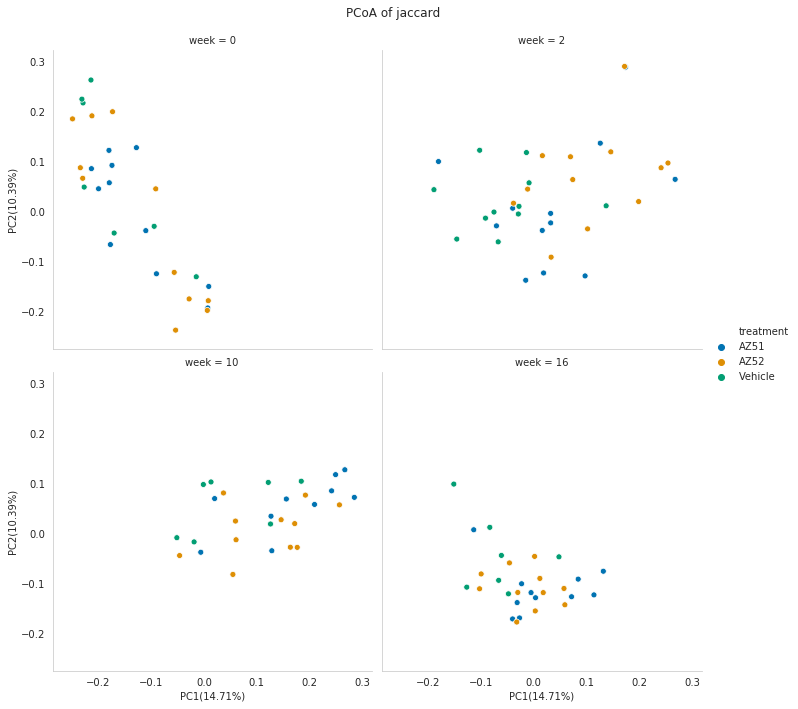

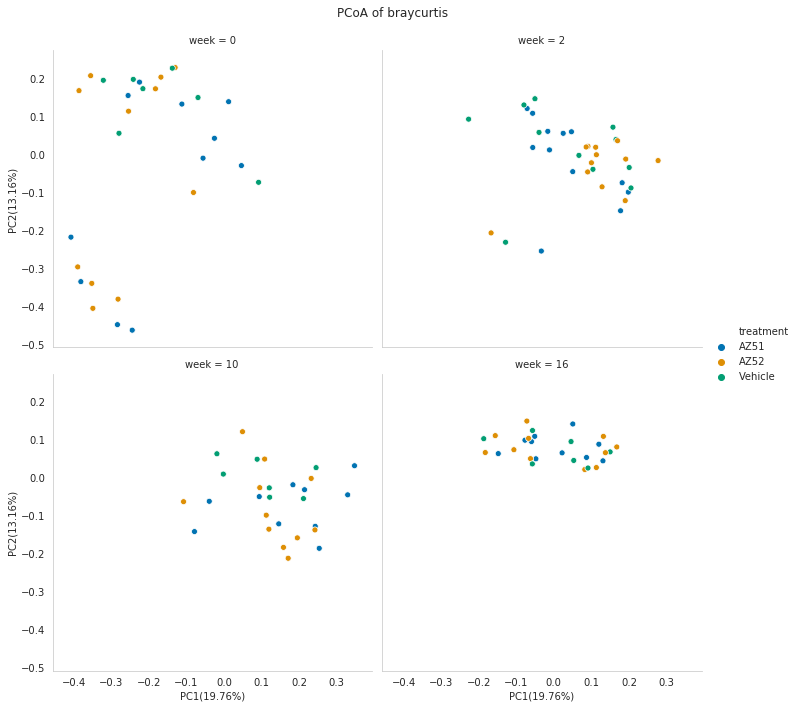

In [24]:
# facet by week
for metric, ordination in pcoa_2d.items():
    ordin_md = ordination.samples.join(sample_md, how='left')
    for cat in metadata_plot_categories:
        factors_in_cat = len(set(ordin_md[cat]))
        perm = permanova(beta_div[metric], sample_md, column=cat)
        p = sns.relplot(data=ordin_md, x='PC1', y='PC2', hue=cat, palette=pal[:factors_in_cat], col='week', col_wrap=2, marker='o')
        p.set_axis_labels(f'PC1({ordination.proportion_explained.PC1:.2%})', 
                          f'PC2({ordination.proportion_explained.PC2:.2%})')
        
        plt.subplots_adjust(top=0.92)
        p.fig.suptitle(f'PCoA of {metric}')
        plt.plot()
        if save_files:
            plt.savefig(f'pcoa_split_{metric}_{cat}.svg')

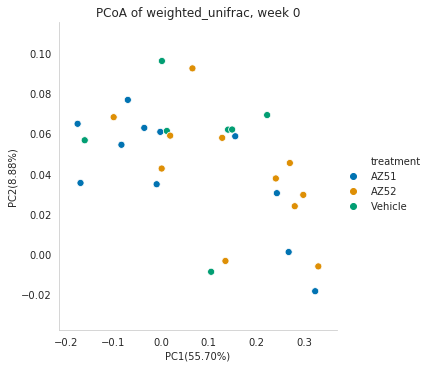

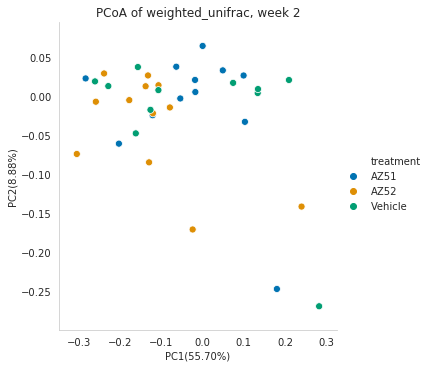

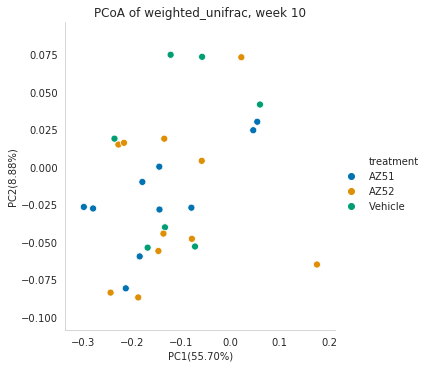

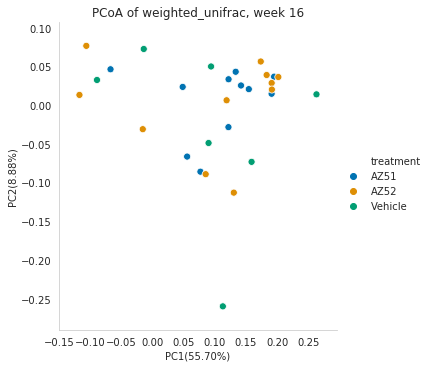

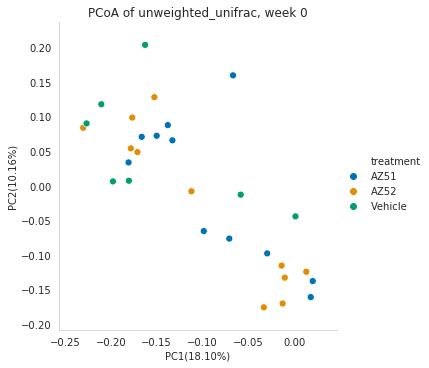

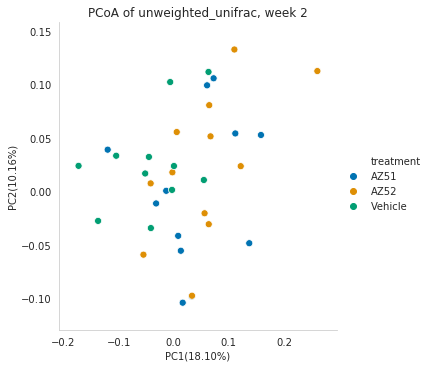

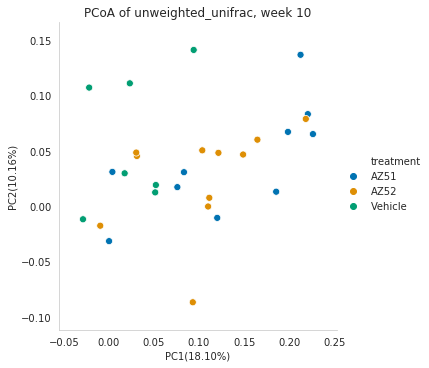

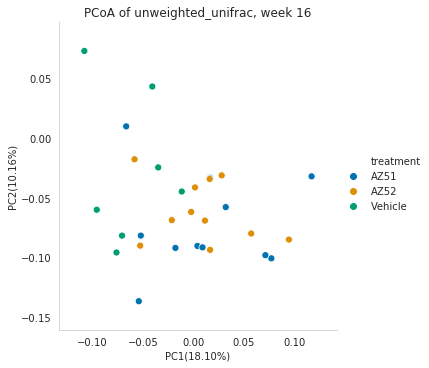

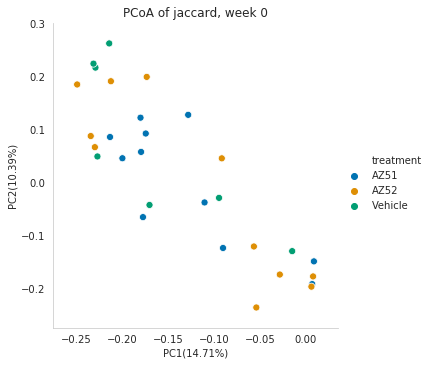

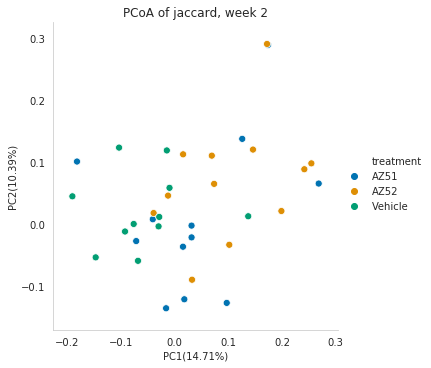

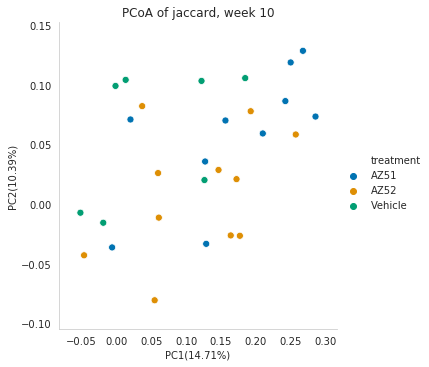

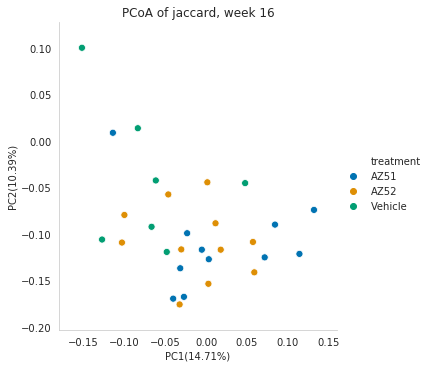

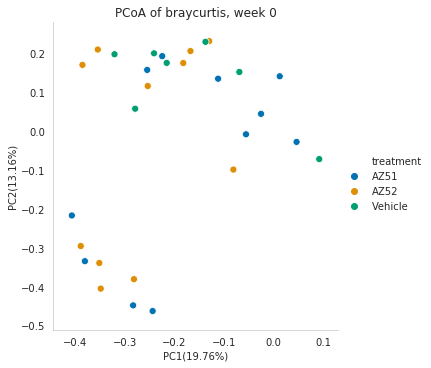

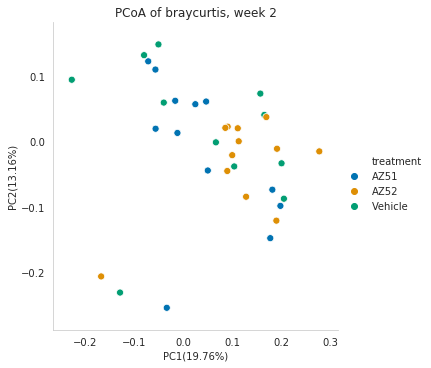

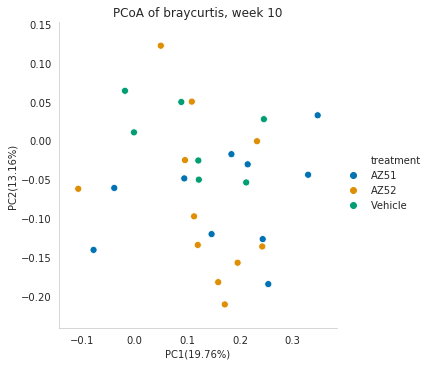

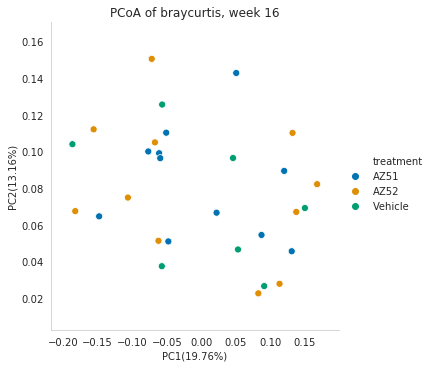

In [25]:
for metric, ordination in pcoa_2d.items():
    if metric != 'weighted_unifrac':
        next
    ordin_md = ordination.samples.join(sample_md, how='left')
    for cat in metadata_plot_categories:
        for week in sorted(set(ordin_md.week)):
            week_ordin = ordin_md[ordin_md.week == week]
            factors_in_cat = len(set(week_ordin[cat]))
            p = sns.relplot(data=week_ordin, x='PC1', y='PC2', hue=cat, palette=pal[0:factors_in_cat], s=50)
            p.set_axis_labels(f'PC1({ordination.proportion_explained.PC1:.2%})', 
                              f'PC2({ordination.proportion_explained.PC2:.2%})')
            plt.title(f'PCoA of {metric}, week {week}')
            plt.plot()
            if save_files:
                plt.savefig(f'pcoa_{metric}_{cat}_{week:02d}.svg')